Deutsch-Jozsa Benchmark Program - Cirq
... execution starting at Jun 06, 2024 04:16:05 UTC
************
Executing [2] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.007, 0.004 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [2] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.006, 0.004 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [2] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.001, 0.006, 0.004 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 1.0, 1.0

************
Executing [2] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.001, 0.007, 0.005 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 1.0, 1.0

************
Executing [2] ci

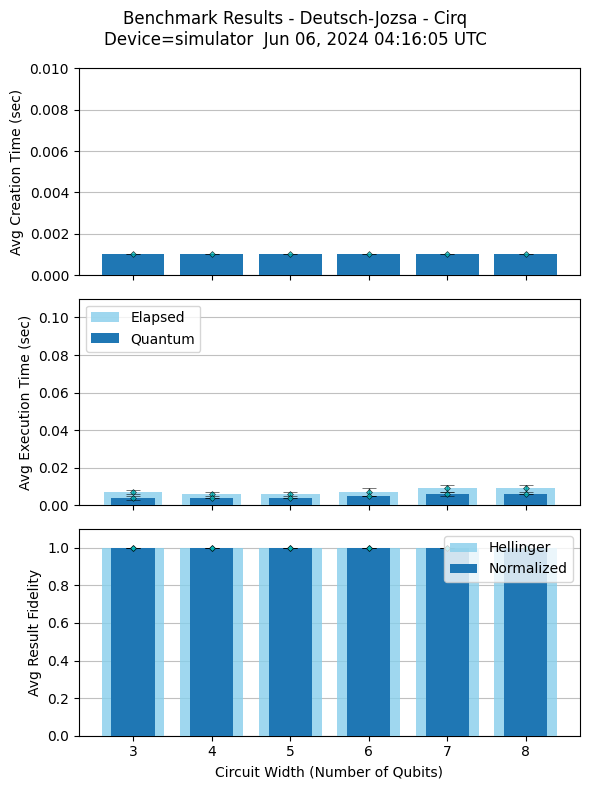

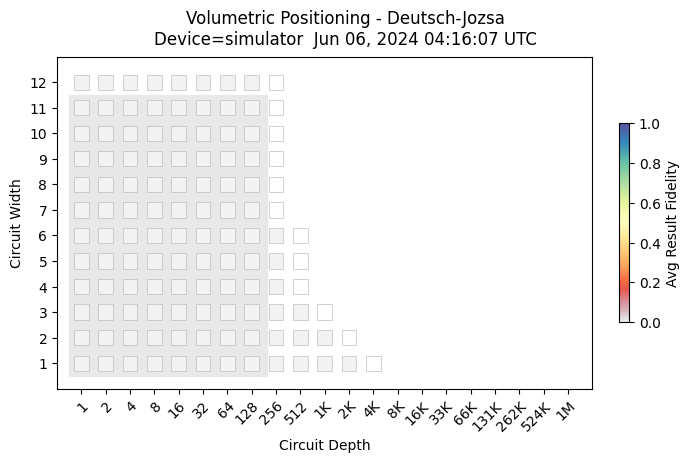

In [1]:
"""
Deutsch-Jozsa Benchmark Program - Cirq
"""

from collections import defaultdict
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = ["_common", "_common/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None

############### Circuit Definition

# Create a constant oracle, appending gates to given circuit
def constant_oracle(input_size, num_qubits):

    #Initialize Quantum Circuit
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    #Added identities because cirq requires gates on each qubit
    for qubit in range(input_size):
        qc.append(cirq.I(qr[qubit]))

    #Add X Gate or Identity at random on last qubit for constant oracle
    output = np.random.randint(2)
    if output == 1:
        qc.append(cirq.X(qr[input_size]))
    else:
        qc.append(cirq.I(qr[input_size]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

# Create a balanced oracle.
# Perform CNOTs with each input qubit as a control and the output bit as the target.
# Vary the input states that give 0 or 1 by wrapping some of the controls in X-gates.
def balanced_oracle(input_size, num_qubits):

    #Initialize Quantum Circuit
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    b_str = "10101010101010101010"  # permit input_string up to 20 chars
    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.append(cirq.X(qr[qubit]))
            
    for qubit in range(input_size):
        qc.append(cirq.CX(qr[qubit], qr[input_size]))

    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.append(cirq.X(qr[qubit]))

    return cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

# Create benchmark circuit
def DeutschJozsa(num_qubits, type):
    # size of input is one less than available qubits
    input_size = num_qubits - 1

    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()

    # start with flipping the ancilla to 1
    qc.append(cirq.X(qr[input_size]))

    # Add Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
        qc.append(cirq.H(qr[i_qubit]))

    # Add a constant or balanced oracle function
    if type == 0:
        Uf = constant_oracle(input_size, num_qubits)
    else:
        Uf = balanced_oracle(input_size, num_qubits)

    qc.append(Uf.on(*qr))
  
    # end with Hadamard on all qubits, excluding ancilla
    for i_qubit in range(input_size):
        qc.append(cirq.H(qr[i_qubit]))

    # uncompute ancilla qubit, not necessary for algorithm
    qc.append(cirq.X(qr[input_size]))
    
    # measure all qubits, excluding ancilla
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(input_size)], key='result'))

    # save smaller circuit example for display
    global QC_, Uf_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf

    # return a handle on the circuit
    return qc


############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, type, num_shots):
    
    # Size of input is one less than available qubits
    input_size = num_qubits - 1

    # get measurement array
    measurements = result.measurements['result']
    
    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
    if verbose: print(f"For type {type} measured: {counts}")

    # create the key that is expected to have all the measurements (for this circuit)
    if type == 0: key = '0'*input_size
    else: key = '1'*input_size
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity


################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=3, max_qubits=8, max_circuits=3, num_shots=100,
        backend_id='simulator', provider_backend=None):

    print("Deutsch-Jozsa Benchmark Program - Cirq")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, type, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(type), num_shots)
        metrics.store_metric(num_qubits, type, 'fidelity', fidelity)

    # Initialize execution module   with the result handler  
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
            
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2, max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over only 2 circuits
        for type in range( num_circuits ):
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = DeutschJozsa(num_qubits, type)
            metrics.store_metric(num_qubits, type, 'create_time', time.time()-ts)

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, type, num_shots)
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(input_size)
    # metrics.report_metrics_for_group(input_size)

    # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # qr_state = [cirq.GridQubit(i, 0) for i in range(Uf_.num_qubits)] # we need to create registers to print circuits in cirq
    # print("\nQuantum Oracle 'Uf' ="); print(cirq.Circuit(cirq.decompose(Uf_.on(*qr_state))) if Uf_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Deutsch-Jozsa - Cirq")


# if main, execute method
if __name__ == '__main__': run()
